# Data Understanding (MC2)

Dataset Description (from VAST 2024 Docs):
- **Graph Type**: Directed Multi-Graph (multiple edges between nodes)
- **Nodes**: 5637
- **Edges**: 271752
- **Connected Component**: 1 (weakly connected)
- **Format**: JSON export from NetworkX (`node_link_data`)
- **Loading**: Use `node_link_graph()` from NetworkX

The scope of this notebook is to understand the structure and metadata of the provided directed multi-graph:
- Types of nodes and edges
- Volume of data (nodes, edges)
- Metadata and relevant attributes
- Prepare for visual analytics and filtering

### Load the Data

The `mc2.json` file is too large to include in the Git repository and is therefore listed in `.gitignore`.

To obtain the original dataset, download it from the official [VAST Challenge 2024 – Mini Challenge 2 (MC2) page](https://vast-challenge.github.io/2024/MC2.html).

Once downloaded, place the file in the `data/` directory (or your preferred location).  
Make sure your code points to the correct file path when loading the data.

In [ ]:
import json
import pandas as pd
import networkx as nx

with open("../data/mc2.json", "r") as f:
    data = json.load(f)

# Create a NetworkX multigraph
G = nx.node_link_graph(data, directed=True, multigraph=True)

print(f"Graph loaded. Total nodes: {G.number_of_nodes()}, total edges: {G.number_of_edges()}")

Graph loaded. Total nodes: 5637, total edges: 271643


## Nodes

In [2]:
# Extract node attributes into a DataFrame
node_data = pd.DataFrame(dict(G.nodes(data=True))).T

node_data.columns

Index(['type', '_last_edited_by', '_date_added', '_last_edited_date',
       '_raw_source', '_algorithm', 'name', 'Name', 'Description',
       'Activities', 'kind', 'qty_tons', 'date', 'flag_country', 'company',
       'tonnage', 'length_overall', 'style', 'fish_species_present'],
      dtype='object')

In [3]:
metadata = ['_last_edited_by', '_last_edited_date', '_date_added', '_raw_source', '_algorithm']

for col in metadata:
    print(f"{col}: {len(node_data[col].unique())} unique values")

_last_edited_by: 11 unique values
_last_edited_date: 500 unique values
_date_added: 525 unique values
_raw_source: 4 unique values
_algorithm: 3 unique values


In [4]:
print(node_data['_last_edited_by'].value_counts(), '\n')

print(node_data['_raw_source'].value_counts(), '\n')

print(node_data['_algorithm'].value_counts(), '\n')


_last_edited_by
Jack Inch           1145
Junior Shurdlu      1116
Melinda Manning     1112
Olokun Daramola     1110
Harvey Janus        1107
Kristin Baker         11
Greta Grass-Hill      10
juniorshurdlu794      10
Clepper Jessen         7
Haenyeo Hyun-Ki        6
Urashima Tarō          3
Name: count, dtype: int64 

_raw_source
Tuna Shelf/egress report         5307
Oceanus Vessel Locator System     296
Oceanus: Geography Notes           24
                                   10
Name: count, dtype: int64 

_algorithm
CatchMate ('arrrr' edition)    5307
OVLS-Catch&Hook                 296
                                 34
Name: count, dtype: int64 



In [5]:
# print range of dates '_date_added' and '_last_edited_date'
print("Date range for '_date_added':", node_data['_date_added'].min(), "to", node_data['_date_added'].max())
print("Date range for '_last_edited_date':", node_data['_last_edited_date'].min(), "to", node_data['_last_edited_date'].max())

Date range for '_date_added': 2033-06-14 to 2035-12-02
Date range for '_last_edited_date': 2033-07-18 to 2035-12-04


Since the metadata looks useless, we drop them:

In [6]:
# Drop metadata columns
node_data = node_data.drop(columns=metadata)

Now, let's analyze each node type...

In [7]:
# Count node types
print("NODE TYPES:")
print(node_data['type'].value_counts())

NODE TYPES:
type
Entity.Document.DeliveryReport    5307
Entity.Vessel.FishingVessel        178
Entity.Vessel.CargoVessel          100
Entity.Location.Point               12
Entity.Commodity.Fish               10
Entity.Location.City                 6
Entity.Vessel.Tour                   6
Entity.Location.Region               6
Entity.Vessel.Other                  5
Entity.Vessel.Ferry.Passenger        3
Entity.Vessel.Ferry.Cargo            2
Entity.Vessel.Research               2
Name: count, dtype: int64


In [8]:
# Display a few nodes of each type
node_data.groupby('type').head(1)

,type,name,Name,Description,Activities,kind,qty_tons,date,flag_country,company,tonnage,length_overall,style,fish_species_present
gadusnspecificatae4ba,Entity.Commodity.Fish,Cod/Gadus n.specificatae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City of Haacklee,Entity.Location.City,NaN,Haacklee,None,"[Tourism, Local shipping]",city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cargo_2035_2394778c,Entity.Document.DeliveryReport,NaN,NaN,NaN,NaN,NaN,24.375,2035-11-03,NaN,NaN,NaN,NaN,NaN,NaN
wavewranglerc2d,Entity.Vessel.FishingVessel,NaN,Wave Wrangler,NaN,NaN,NaN,NaN,NaN,Oceanus,"Roth, Logan and Moreno",700,110,NaN,NaN
webigailba7,Entity.Vessel.Other,NaN,Webigail,NaN,NaN,NaN,NaN,NaN,Oceanus,NaN,NaN,50,NaN,NaN
venerable89c,Entity.Vessel.Ferry.Passenger,NaN,Venerable,NaN,NaN,NaN,NaN,NaN,Oceanus,NaN,NaN,NaN,NaN,NaN
seawaysavvy9847,Entity.Vessel.CargoVessel,NaN,Seaway Savvy 9,NaN,NaN,NaN,NaN,NaN,Osterivaro,NaN,2100,90,NaN,NaN
sturdyd7f,Entity.Vessel.Ferry.Cargo,NaN,Sturdy,NaN,NaN,NaN,NaN,NaN,Oceanus,NaN,NaN,NaN,NaN,NaN
inquisitive8c0,Entity.Vessel.Research,NaN,Inquisitive,NaN,NaN,NaN,NaN,NaN,Oceanus,NaN,NaN,NaN,NaN,NaN
himarkroyal032,Entity.Vessel.Tour,NaN,Himark Royal,NaN,NaN,NaN,NaN,NaN,Oceanus,NaN,NaN,NaN,NaN,NaN


### Entity.Location

In [9]:
points = cities = node_data[node_data['type'] == 'Entity.Location.Point']
cities = node_data[node_data['type'] == 'Entity.Location.City']
regions = node_data[node_data['type'] == 'Entity.Location.Region']

In [10]:
points

,type,name,Name,Description,Activities,kind,qty_tons,date,flag_country,company,tonnage,length_overall,style,fish_species_present
Exit West,Entity.Location.Point,NaN,Exit West,None,"[International shipping, Deep sea fishing]",buoy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nav 3,Entity.Location.Point,NaN,Nav 3,Navigation in/out of South Paackland,[Navigation],buoy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nav D,Entity.Location.Point,NaN,Nav D,Safe navigation around Nemo Reef,[Navigation],buoy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nav B,Entity.Location.Point,NaN,Nav B,Safe Navigation around Limpet Preserve,[Navigation],buoy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nav A,Entity.Location.Point,NaN,Nav A,Safe Navigation around Limpet Preserve,[Navigation],buoy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nav C,Entity.Location.Point,NaN,Nav C,Safe Navigation near Lomark,[Navigation],buoy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nav 2,Entity.Location.Point,NaN,Nav 2,Safe navigation near Ghoti Preserve and Paackland,[Navigation],buoy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nav 1,Entity.Location.Point,NaN,Nav 1,Navigation north of Ghoti Preserve,[Navigation],buoy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exit East,Entity.Location.Point,NaN,Exit East,None,"[International shipping, Deep sea fishing]",buoy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exit South,Entity.Location.Point,NaN,Exit South,None,"[International shipping, Deep sea fishing]",buoy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
cities

,type,name,Name,Description,Activities,kind,qty_tons,date,flag_country,company,tonnage,length_overall,style,fish_species_present
City of Haacklee,Entity.Location.City,NaN,Haacklee,None,"[Tourism, Local shipping]",city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City of Lomark,Entity.Location.City,NaN,Lomark,None,"[Deep sea fishing, Commercial fishing, Tourism...",city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City of Himark,Entity.Location.City,NaN,Himark,None,"[Recreation, tourism]",city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City of Paackland,Entity.Location.City,NaN,Paackland,None,"[Industry, Fishing industry, Local shipping, T...",city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City of South Paackland,Entity.Location.City,NaN,South Paackland,None,"[Industry, Fishing industry, Local shipping]",city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City of Port Grove,Entity.Location.City,NaN,Port Grove,None,"[Tourism, Research]",city,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
regions

,type,name,Name,Description,Activities,kind,qty_tons,date,flag_country,company,tonnage,length_overall,style,fish_species_present
Cod Table,Entity.Location.Region,NaN,Cod Table,,[Commercial fishing],Fishing Ground,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Cod/Gadus n.specificatae, Birdseye/Pisces fri..."
Ghoti Preserve,Entity.Location.Region,NaN,Ghoti Preserve,,"[Research, Tourism, Recreation]",Ecological Preserve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Wrasse/Labridae n.refert, Beauvoir/Habeas pis..."
Wrasse Beds,Entity.Location.Region,NaN,Wrasse Beds,,[Commercial fishing],Fishing Ground,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Wrasse/Labridae n.refert, Birdseye/Pisces fri..."
Nemo Reef,Entity.Location.Region,NaN,Nemo Reef,,"[Recreation, Tourism]",Ecological Preserve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Wrasse/Labridae n.refert, Tuna/Thunnini n.ver..."
Don Limpet Preserve,Entity.Location.Region,NaN,Don Limpet Preserve,,"[Recreation, Tourism]",Ecological Preserve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Tuna/Thunnini n.vera, Birdseye/Pisces frigus,..."
Tuna Shelf,Entity.Location.Region,NaN,Tuna Shelf,,"[Commercial fishing, Sport fishing]",Fishing Ground,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Tuna/Thunnini n.vera, Birdseye/Pisces frigus,..."


We now have the illegal regions for fishing:

In [13]:
illegal_fishing_locations = ['Ghoti Preserve', 'Nemo Reef', 'Don Limpet Preserve']

In [14]:
location_metadata = ['Name', 'Activities', 'Description', 'fish_species_present', 'kind']

# Print missing values for each location metadata field
print('REGIONS:')
for meta in location_metadata:
    missing = regions[meta].isnull().sum()
    print(f"Missing values in '{meta}': {missing} out of {len(regions)} total points")

print('\nCITIES:')
for meta in location_metadata:
    missing = cities[meta].isnull().sum()
    print(f"Missing values in '{meta}': {missing} out of {len(cities)} total points")

print('\nPOINTS:')
for meta in location_metadata:
    missing = points[meta].isnull().sum()
    print(f"Missing values in '{meta}': {missing} out of {len(points)} total points")

REGIONS:
Missing values in 'Name': 0 out of 6 total points
Missing values in 'Activities': 0 out of 6 total points
Missing values in 'Description': 0 out of 6 total points
Missing values in 'fish_species_present': 0 out of 6 total points
Missing values in 'kind': 0 out of 6 total points

CITIES:
Missing values in 'Name': 0 out of 6 total points
Missing values in 'Activities': 0 out of 6 total points
Missing values in 'Description': 6 out of 6 total points
Missing values in 'fish_species_present': 6 out of 6 total points
Missing values in 'kind': 0 out of 6 total points

POINTS:
Missing values in 'Name': 0 out of 12 total points
Missing values in 'Activities': 0 out of 12 total points
Missing values in 'Description': 4 out of 12 total points
Missing values in 'fish_species_present': 12 out of 12 total points
Missing values in 'kind': 0 out of 12 total points


### Entity.Commodity.Fish

In [15]:
commodities = node_data[node_data['type'] == 'Entity.Commodity.Fish']

commodities

,type,name,Name,Description,Activities,kind,qty_tons,date,flag_country,company,tonnage,length_overall,style,fish_species_present
gadusnspecificatae4ba,Entity.Commodity.Fish,Cod/Gadus n.specificatae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
piscesfrigus900,Entity.Commodity.Fish,Birdseye/Pisces frigus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
piscesfoetidaae7,Entity.Commodity.Fish,Sockfish/Pisces foetida,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
labridaenrefert9be,Entity.Commodity.Fish,Wrasse/Labridae n.refert,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
habeaspisces4eb,Entity.Commodity.Fish,Beauvoir/Habeas pisces,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
piscissapidum9b7,Entity.Commodity.Fish,Harland/Piscis sapidum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thunnininveradb7,Entity.Commodity.Fish,Tuna/Thunnini n.vera,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
piscisosseusb6d,Entity.Commodity.Fish,Offidiaa/Piscis osseus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oncorhynchusrosea790,Entity.Commodity.Fish,Salmon/Oncorhynchus rosea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
piscessatisb87,Entity.Commodity.Fish,Helenaa/Pisces satis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
commodity_metadata = ['name']

# Print missing values for each commodity metadata field
for meta in commodity_metadata:
    missing = commodities[meta].isnull().sum()
    print(f"Missing values in '{meta}': {missing} out of {len(commodities)} total points")

Missing values in 'name': 0 out of 10 total points


### Entity.Vessel

In [17]:
vessel_types = ['Entity.Vessel.FishingVessel', 'Entity.Vessel.Ferry.Passenger', 'Entity.Vessel.CargoVessel', 'Entity.Vessel.Ferry.Cargo', 'Entity.Vessel.Tour', 'Entity.Vessel.Research', 'Entity.Vessel.Other']
vessels = node_data[node_data['type'].isin(vessel_types)]

fishing_vessels = vessels[vessels['type'] == 'Entity.Vessel.FishingVessel']
ferry_vessels = vessels[vessels['type'] == 'Entity.Vessel.Ferry.Passenger']
cargo_vessels = vessels[vessels['type'] == 'Entity.Vessel.CargoVessel']
ferry_cargo_vessels = vessels[vessels['type'] == 'Entity.Vessel.Ferry.Cargo']
tour_vessels = vessels[vessels['type'] == 'Entity.Vessel.Tour']
research_vessels = vessels[vessels['type'] == 'Entity.Vessel.Research']
other_vessels = vessels[vessels['type'] == 'Entity.Vessel.Other']

vessels.head()

,type,name,Name,Description,Activities,kind,qty_tons,date,flag_country,company,tonnage,length_overall,style,fish_species_present
wavewranglerc2d,Entity.Vessel.FishingVessel,NaN,Wave Wrangler,NaN,NaN,NaN,NaN,NaN,Oceanus,"Roth, Logan and Moreno",700,110,NaN,NaN
yellowfintunataker08b,Entity.Vessel.FishingVessel,NaN,Yellowfin Tuna Taker,NaN,NaN,NaN,NaN,NaN,Oceanus,Brown-Haas,4500,110,NaN,NaN
webigailba7,Entity.Vessel.Other,NaN,Webigail,NaN,NaN,NaN,NaN,NaN,Oceanus,NaN,NaN,50,NaN,NaN
arcticgraylingangler094,Entity.Vessel.FishingVessel,NaN,Arctic Grayling Angler,NaN,NaN,NaN,NaN,NaN,Oceanus,"Smith, Davis and Acosta",1500,80,NaN,NaN
anchovyassaulterb1c,Entity.Vessel.FishingVessel,NaN,Anchovy Assaulter,NaN,NaN,NaN,NaN,NaN,Oceanus,Cisneros-Meyer,400,60,NaN,NaN


In [18]:
vessel_metadata = ['Name', 'company', 'flag_country', 'length_overall', 'tonnage']

# Print missing values for each vessel metadata field
print('FISHING VESSELS:')
for meta in vessel_metadata:
    missing = fishing_vessels[meta].isnull().sum()
    print(f"Missing values in '{meta}': {missing} out of {len(fishing_vessels)} total points")

print('\nFERRY VESSELS:')
for meta in vessel_metadata:
    missing = ferry_vessels[meta].isnull().sum()
    print(f"Missing values in '{meta}': {missing} out of {len(ferry_vessels)} total points")

print('\nCARGO VESSELS:')
for meta in vessel_metadata:
    missing = cargo_vessels[meta].isnull().sum()
    print(f"Missing values in '{meta}': {missing} out of {len(cargo_vessels)} total points")

print('\nFERRY CARGO VESSELS:')
for meta in vessel_metadata:
    missing = ferry_cargo_vessels[meta].isnull().sum()
    print(f"Missing values in '{meta}': {missing} out of {len(ferry_cargo_vessels)} total points")

print('\nTOUR VESSELS:')
for meta in vessel_metadata:
    missing = tour_vessels[meta].isnull().sum()
    print(f"Missing values in '{meta}': {missing} out of {len(tour_vessels)} total points")

print('\nRESEARCH VESSELS:')
for meta in vessel_metadata:
    missing = research_vessels[meta].isnull().sum()
    print(f"Missing values in '{meta}': {missing} out of {len(research_vessels)} total points")

print('\nOTHER VESSELS:')
for meta in vessel_metadata:
    missing = other_vessels[meta].isnull().sum()
    print(f"Missing values in '{meta}': {missing} out of {len(other_vessels)} total points")

FISHING VESSELS:
Missing values in 'Name': 0 out of 178 total points
Missing values in 'company': 0 out of 178 total points
Missing values in 'flag_country': 0 out of 178 total points
Missing values in 'length_overall': 0 out of 178 total points
Missing values in 'tonnage': 0 out of 178 total points

FERRY VESSELS:
Missing values in 'Name': 0 out of 3 total points
Missing values in 'company': 3 out of 3 total points
Missing values in 'flag_country': 0 out of 3 total points
Missing values in 'length_overall': 3 out of 3 total points
Missing values in 'tonnage': 3 out of 3 total points

CARGO VESSELS:
Missing values in 'Name': 0 out of 100 total points
Missing values in 'company': 99 out of 100 total points
Missing values in 'flag_country': 0 out of 100 total points
Missing values in 'length_overall': 0 out of 100 total points
Missing values in 'tonnage': 0 out of 100 total points

FERRY CARGO VESSELS:
Missing values in 'Name': 0 out of 2 total points
Missing values in 'company': 2 out o

### Entity.Document.DeliveryReport

In [19]:
documents = node_data[node_data['type'] == 'Entity.Document.DeliveryReport']

documents.head()

,type,name,Name,Description,Activities,kind,qty_tons,date,flag_country,company,tonnage,length_overall,style,fish_species_present
cargo_2035_2394778c,Entity.Document.DeliveryReport,NaN,NaN,NaN,NaN,NaN,24.375,2035-11-03,NaN,NaN,NaN,NaN,NaN,NaN
cargo_2035_23956ba0,Entity.Document.DeliveryReport,NaN,NaN,NaN,NaN,NaN,18.125,2035-08-16,NaN,NaN,NaN,NaN,NaN,NaN
cargo_2035_23957cfd,Entity.Document.DeliveryReport,NaN,NaN,NaN,NaN,NaN,20.625,2035-08-20,NaN,NaN,NaN,NaN,NaN,NaN
cargo_2035_23958501,Entity.Document.DeliveryReport,NaN,NaN,NaN,NaN,NaN,13.125,2035-11-07,NaN,NaN,NaN,NaN,NaN,NaN
cargo_2035_23959ab6,Entity.Document.DeliveryReport,NaN,NaN,NaN,NaN,NaN,13.125,2035-08-24,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
document_metadata = ['qty_tons', 'date']

for meta in document_metadata:
    missing = documents[meta].isnull().sum()
    print(f"Missing values in '{meta}': {missing} out of {len(documents)} total points")

Missing values in 'qty_tons': 0 out of 5307 total points
Missing values in 'date': 0 out of 5307 total points


## Edges

In [21]:
# Extract all edges with their attributes into a clean list of dictionaries
edge_data = pd.DataFrame([
    {
        "source": u,
        "target": v,
        "key": k,
        **attr
    }
    for u, v, k, attr in G.edges(data=True, keys=True)
])

edge_data.columns.tolist()

['source',
 'target',
 'key',
 'type',
 'time',
 'dwell',
 '_last_edited_by',
 '_date_added',
 '_last_edited_date',
 '_raw_source',
 '_algorithm',
 'date',
 'data_author',
 'aphorism',
 'holiday_greeting',
 'wisdom',
 'saying of the sea']

In [22]:
metadata = ['_last_edited_by', '_last_edited_date', '_date_added', '_raw_source', '_algorithm']

for col in metadata:
    print(f"{col}: {len(edge_data[col].unique())} unique values")

_last_edited_by: 8 unique values
_last_edited_date: 32521 unique values
_date_added: 17308 unique values
_raw_source: 8 unique values
_algorithm: 3 unique values


Again, we drop the metadata columns:

In [23]:
# Drop metadata columns
edge_data = edge_data.drop(columns=metadata)

We analyze the edge types one by one...

In [24]:
# Count edge types
print("EDGE TYPES:")
print(edge_data['type'].value_counts())

EDGE TYPES:
type
Event.TransportEvent.TransponderPing    258542
Event.Transaction                        10614
Event.HarborReport                        2487
Name: count, dtype: int64


The (directed) edges in the graph represent **events or relationships** between entities, either:
1. **VESSEL MOVEMENTS** – a vessel visiting a location (`Event.TransportEvent.TransponderPing`)
2. **HARBOR IMPORT RECORDS** – a commodity being delivered (`Event.Transaction`)
3. **HARBOR REPORTS** – or a harbor report being filed (`Event.HarborReport`)

In [25]:
# Display a few edges of each type
edge_data.groupby('type').head(1)

,source,target,key,type,time,dwell,date,data_author,aphorism,holiday_greeting,wisdom,saying of the sea
0,City of Haacklee,perchplundererbc0,0,Event.TransportEvent.TransponderPing,2035-09-16T04:06:48.185987,115074.790577,NaN,NaN,NaN,NaN,NaN,NaN
22674,cargo_2035_2394778c,gadusnspecificatae4ba,0,Event.Transaction,NaN,NaN,2035-11-03,NaN,NaN,NaN,NaN,NaN
33288,wavewranglerc2d,City of Haacklee,0,Event.HarborReport,NaN,NaN,2035-09-14,Portmaster of Haacklee,"The sea-shore is a sort of neutral ground, a m...",What are you doing for Saw Appreciation Day th...,"Boats, like whiskey, are all good.",An island is a world apart.


In [26]:
transponder_pings = edge_data[edge_data['type'] == 'Event.TransportEvent.TransponderPing']
transactions = edge_data[edge_data['type'] == 'Event.Transaction']
harbor_reports = edge_data[edge_data['type'] == 'Event.HarborReport']

In [27]:
print('TRANSPONDER PINGS:')
for col in transponder_pings.columns:
    missing = transponder_pings[col].isnull().sum()
    print(f"Missing values in '{col}': {missing} out of {len(transponder_pings)} total points")

print('\nTRANSACTIONS:')
for col in transactions.columns:
    missing = transactions[col].isnull().sum()
    print(f"Missing values in '{col}': {missing} out of {len(transactions)} total points")

print('\nHARBOR REPORTS:')
for col in harbor_reports.columns:
    missing = harbor_reports[col].isnull().sum()
    print(f"Missing values in '{col}': {missing} out of {len(harbor_reports)} total points")

TRANSPONDER PINGS:
Missing values in 'source': 0 out of 258542 total points
Missing values in 'target': 0 out of 258542 total points
Missing values in 'key': 0 out of 258542 total points
Missing values in 'type': 0 out of 258542 total points
Missing values in 'time': 0 out of 258542 total points
Missing values in 'dwell': 0 out of 258542 total points
Missing values in 'date': 258542 out of 258542 total points
Missing values in 'data_author': 258542 out of 258542 total points
Missing values in 'aphorism': 258542 out of 258542 total points
Missing values in 'holiday_greeting': 258542 out of 258542 total points
Missing values in 'wisdom': 258542 out of 258542 total points
Missing values in 'saying of the sea': 258542 out of 258542 total points

TRANSACTIONS:
Missing values in 'source': 0 out of 10614 total points
Missing values in 'target': 0 out of 10614 total points
Missing values in 'key': 0 out of 10614 total points
Missing values in 'type': 0 out of 10614 total points
Missing values 

We drop useless metadata from each edge type:

In [28]:
cols_to_drop = ['aphorism', 'holiday_greeting', 'wisdom', 'saying of the sea']

transponder_pings = transponder_pings.drop(columns=['date', 'data_author'] + cols_to_drop)
transactions = transactions.drop(columns=['time', 'dwell', 'data_author'] + cols_to_drop)
harbor_reports = harbor_reports.drop(columns=['time', 'dwell'] + cols_to_drop)

Now we convert dwell and time to a readable and standard format:

In [29]:
# Convert 'time' column to numeric, coercing errors to NaN
transponder_pings['time'] = pd.to_datetime(transponder_pings['time'], errors='coerce')
transactions['date'] = pd.to_datetime(transactions['date'], errors='coerce')
harbor_reports['date'] = pd.to_datetime(harbor_reports['date'], errors='coerce')

# Adding a new column converting dwell from seconds to hours
transponder_pings['dwell_hours'] = transponder_pings['dwell'] / 3600

# Adding a new column converting dwell from hours to days
transponder_pings['dwell_days'] = transponder_pings['dwell_hours'] / 24

In [30]:
for col in transponder_pings.columns:
    print(col, transponder_pings[col].dtype)

source object
target object
key int64
type object
time datetime64[ns]
dwell float64
dwell_hours float64
dwell_days float64


In [31]:
transponder_pings.head()

,source,target,key,type,time,dwell,dwell_hours,dwell_days
0,City of Haacklee,perchplundererbc0,0,Event.TransportEvent.TransponderPing,2035-09-16 04:06:48.185987,115074.790577,31.965220,1.331884
1,City of Haacklee,perchplundererbc0,1,Event.TransportEvent.TransponderPing,2035-09-20 05:21:33.678120,412706.321880,114.640645,4.776694
2,City of Haacklee,perchplundererbc0,2,Event.TransportEvent.TransponderPing,2035-09-28 04:31:47.118191,286092.881809,79.470245,3.311260
3,City of Haacklee,perchplundererbc0,3,Event.TransportEvent.TransponderPing,2035-10-04 04:59:36.052683,327623.947317,91.006652,3.791944
4,City of Haacklee,perchplundererbc0,4,Event.TransportEvent.TransponderPing,2035-10-15 04:26:14.647650,243225.352350,67.562598,2.815108


In [32]:
for col in transactions.columns:
    print(col, transactions[col].dtype)

source object
target object
key int64
type object
date datetime64[ns]


In [33]:
transactions.head()

,source,target,key,type,date
22674,cargo_2035_2394778c,gadusnspecificatae4ba,0,Event.Transaction,2035-11-03
22675,cargo_2035_2394778c,City of South Paackland,0,Event.Transaction,2035-11-03
22676,cargo_2035_23956ba0,gadusnspecificatae4ba,0,Event.Transaction,2035-08-16
22677,cargo_2035_23956ba0,City of South Paackland,0,Event.Transaction,2035-08-16
22678,cargo_2035_23957cfd,gadusnspecificatae4ba,0,Event.Transaction,2035-08-20


In [34]:
for col in harbor_reports.columns:
    print(col, harbor_reports[col].dtype)

source object
target object
key int64
type object
date datetime64[ns]
data_author object


In [35]:
harbor_reports.head()

,source,target,key,type,date,data_author
33288,wavewranglerc2d,City of Haacklee,0,Event.HarborReport,2035-09-14,Portmaster of Haacklee
33289,wavewranglerc2d,City of Haacklee,1,Event.HarborReport,2035-08-20,Portmaster of Haacklee
33290,wavewranglerc2d,City of Haacklee,2,Event.HarborReport,2035-09-17,Portmaster of Haacklee
33291,wavewranglerc2d,City of Himark,0,Event.HarborReport,2035-08-16,Portmaster of Himark
33292,wavewranglerc2d,City of Himark,1,Event.HarborReport,2035-09-21,Portmaster of Himark


# Descriptive Statistics & Preliminary Visual Analysis

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

Prepare the data...

In [37]:
# Merge on 'target' by resetting the index of vessels
vessels_reset = vessels.reset_index().rename(columns={'index': 'target'})
transponder_pings_merged = transponder_pings.merge(vessels_reset, on='target', how='left')

# Merge on 'source' by resetting the index of vessels
vessels_reset = vessels.reset_index().rename(columns={'index': 'source'})
harbor_reports_merged = harbor_reports.merge(vessels_reset, on='source', how='left')

# Rename columns
transponder_pings_merged = transponder_pings_merged.rename(columns={'type_y': 'vessel_type', 'type_x': 'event_type'})
harbor_reports_merged = harbor_reports_merged.rename(columns={'type_y': 'vessel_type', 'type_x': 'event_type', 'date_x':'date'})

Let's analyze **dwell time** by vessel type and source location:

In [38]:
print(transponder_pings_merged.groupby('vessel_type')['dwell_hours'].describe().to_string())

                                  count       mean        std       min       25%       50%       75%          max
vessel_type                                                                                                       
Entity.Vessel.CargoVessel        6239.0   4.950617   9.392983  0.000000  0.958439  2.008782  4.449028   150.697783
Entity.Vessel.Ferry.Cargo        2299.0   5.886577  19.056124  0.000000  1.097232  1.609811  2.950762   152.176139
Entity.Vessel.Ferry.Passenger    9472.0   1.912313   8.470539  0.000000  0.583043  0.851157  1.137924    96.813893
Entity.Vessel.FishingVessel    227957.0   5.385989  11.663285  0.000000  1.354728  1.798011  3.451696   287.526087
Entity.Vessel.Other              2586.0  13.949763  32.840011  0.678852  1.709971  2.592924  8.916125   569.431097
Entity.Vessel.Research           2498.0   5.464061  21.624417  0.000000  0.743886  0.940313  1.280211   153.759645
Entity.Vessel.Tour               7491.0  10.704628  94.647188  0.000000  0.55869

In [39]:
print(transponder_pings_merged.groupby('source')['dwell_hours'].describe().to_string())

                           count       mean        std       min        25%        50%        75%          max
source                                                                                                        
City of Haacklee          4520.0  20.085252  25.925813  0.000000   1.698765  11.267260  30.127043   287.526087
City of Himark            3328.0  31.222910  24.881478  0.000000  13.294963  28.194173  41.833815   227.760692
City of Lomark            4863.0  26.832637  25.182988  0.000000   2.978851  22.059346  38.481931   136.196267
City of Paackland         5888.0  33.906861  31.583040  0.000000  11.442995  26.963074  49.472031   289.505374
City of Port Grove        2144.0  12.138713  28.284421  0.000000   0.567998   1.320708   6.965686   147.449650
City of South Paackland   4075.0  30.565333  28.233210  0.000000  13.784411  24.328754  41.684855   569.431097
Cod Table                48352.0   6.092027   5.171619  1.022692   2.779362   4.610386   7.820726   153.759645
D

In [40]:
# Cap to the 95th percentile to avoid outliers skewing the analysis
cap = transponder_pings_merged['dwell_hours'].quantile(0.95)
transponder_pings_merged_filtered = transponder_pings_merged[transponder_pings_merged['dwell_hours'] <= cap]

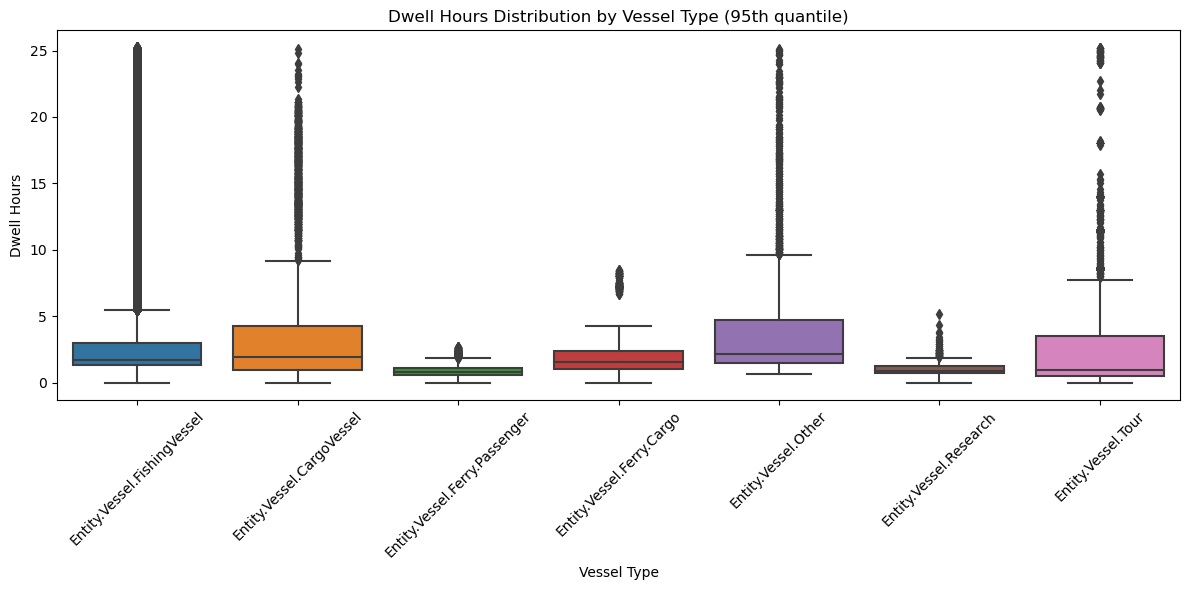

In [41]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=transponder_pings_merged_filtered, x='vessel_type', y='dwell_hours')
plt.xticks(rotation=45)
plt.title('Dwell Hours Distribution by Vessel Type (95th quantile)')
plt.xlabel('Vessel Type')
plt.ylabel('Dwell Hours')
plt.tight_layout()
plt.show()

Are fishing vessels staying longer than usual at certain ports?

Is a ferry showing suspiciously long dwell times (unusual)?

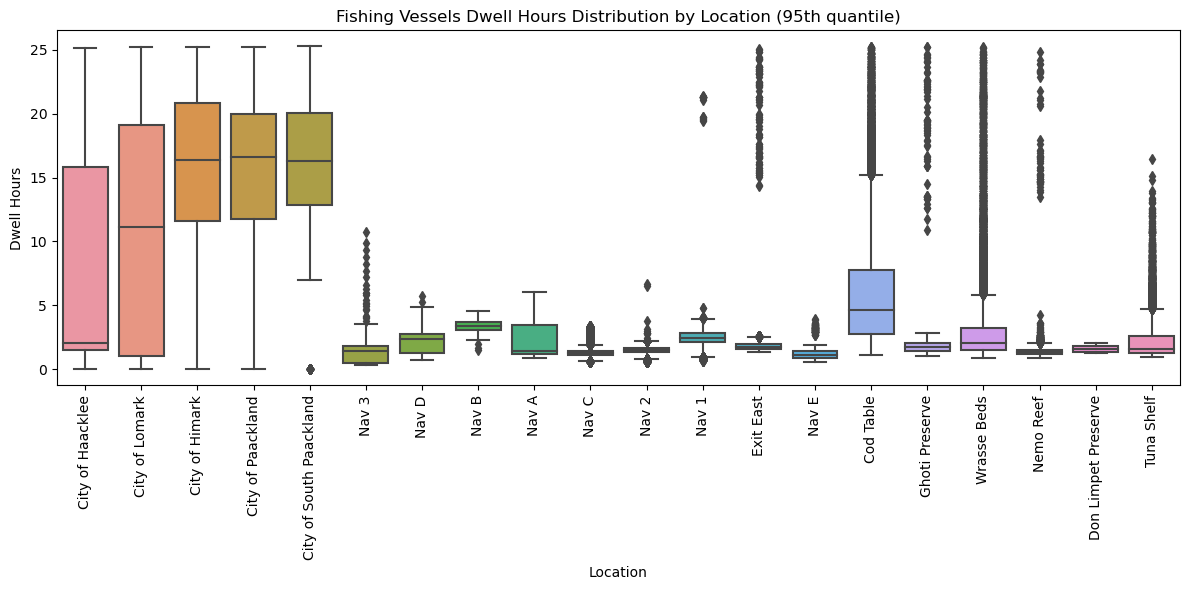

In [42]:
# Filtered for fishing-specific vessel types...

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=transponder_pings_merged_filtered[transponder_pings_merged_filtered['vessel_type'].isin(['Entity.Vessel.FishingVessel'])], 
    x='source', 
    y='dwell_hours')
plt.xticks(rotation=90)
plt.title('Fishing Vessels Dwell Hours Distribution by Location (95th quantile)')
plt.xlabel('Location')
plt.ylabel('Dwell Hours')
plt.tight_layout()
plt.show()

In [43]:
# Filter and compute total dwell time per vessel
ranking_illegal_dwellers = (
    transponder_pings_merged[
        (transponder_pings_merged['source'].isin(illegal_fishing_locations)) &
        (transponder_pings_merged['vessel_type'] == 'Entity.Vessel.FishingVessel')
    ]
    .groupby('target')['dwell_hours']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Rename columns for clarity
ranking_illegal_dwellers.columns = ['Vessel ID', 'Total Dwell Time (hours)']

print("All Fishing Vessels ranked by Dwell Time in Illegal Fishing Locations:\n")
print(ranking_illegal_dwellers.to_string(index=True))

All Fishing Vessels ranked by Dwell Time in Illegal Fishing Locations:

                       Vessel ID  Total Dwell Time (hours)
0              bluefishbandit8ec               1441.268794
1            anchovyassaulterb1c               1293.728694
2         europeanperchpirated9b               1194.727124
3                 halibuthero9b9               1154.999549
4          yellowfintunataker08b                998.002294
5         welscatfishwrangler6ae                997.544130
6      chainpickerelplunderer039                980.943101
7                  soleseeker47a                968.534479
8               snooksnatcherbdb                965.141508
9          pacificcodcapturer81c                943.702406
10           herringharpooner843                913.986128
11             deepseadrifter9f2                859.764683
12              haddockhunter1a7                846.085657
13             bluegillbandita5f                802.346286
14               marlinmaster8ab           

In [44]:
fishing_vessel_ids = fishing_vessels.index.to_list()
pinged_vessel_ids = transponder_pings_merged[transponder_pings_merged['vessel_type'] == 'Entity.Vessel.FishingVessel']['target'].unique()

print(f"All vessels have been pinged at least once since the pinged fishing vessels are {len(pinged_vessel_ids)} out of {len(fishing_vessel_ids)} fishing vessels.")

print(f"\nThe number of fishing vessels caught in illegal fishing locations are {len(ranking_illegal_dwellers)}.")

All vessels have been pinged at least once since the pinged fishing vessels are 178 out of 178 fishing vessels.

The number of fishing vessels caught in illegal fishing locations are 131.


Let's analyze **time gaps** between pings:

In [45]:
# Sort by vessel (target) and time
sorted_pings = transponder_pings_merged[transponder_pings_merged['vessel_type'] == 'Entity.Vessel.FishingVessel'].sort_values(by=['target', 'time'])

# Compute end time of dwell
sorted_pings['end_time'] = sorted_pings['time'] + pd.to_timedelta(sorted_pings['dwell'], unit='s')

# Group by vessel and shift to get previous end_time
sorted_pings['prev_end'] = sorted_pings.groupby('target')['end_time'].shift()

# Calculate gap between pings (in seconds)
sorted_pings['gap'] = (sorted_pings['time'] - sorted_pings['prev_end']).dt.total_seconds()

# Remove negative or null values
sorted_pings['gap'] = sorted_pings['gap'].apply(lambda x: x if x and x > 0 else 0)

# Sum gaps per vessel (in hours)
gap_df = (
    sorted_pings
    .groupby('target')['gap']
    .sum()
    .div(3600)  # convert to hours
    .sort_values(ascending=False)
    .reset_index()
)

# Rename columns
gap_df.columns = ['vessel_id', 'total_gap_hours']

# Add ranking column (1-based index)
gap_df.index = gap_df.index + 1
gap_df.index.name = 'rank'

print("Top Vessels with Most Transponder Gaps (in hours):\n")
print(gap_df.round(2).to_string())

Top Vessels with Most Transponder Gaps (in hours):

                          vessel_id  total_gap_hours
rank                                                
1           longnosesuckerseeker6ab          1173.41
2                    tunatrawlerafd          1062.62
3                 musselmaraudere9b          1002.10
4            whitemarlinwranglerbac           843.02
5          europeaneelenthusiastf9f           837.81
6                 albacoreangler47d           777.25
7                  eelenthusiast8c6           769.07
8                    seaswindler255           741.91
9                 brinebuccaneer9fd           740.04
10         flatheadcatfishfindera51           735.90
11                 pikeplunderer0ca           734.50
12               laketroutlooter534           732.05
13         cutthroattroutcatchere2b           720.14
14            whitefishwhisperer6df           708.33
15         grasspickerelgangster7d1           707.49
16                   oceanreaper44a           6

/Users/matilde/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


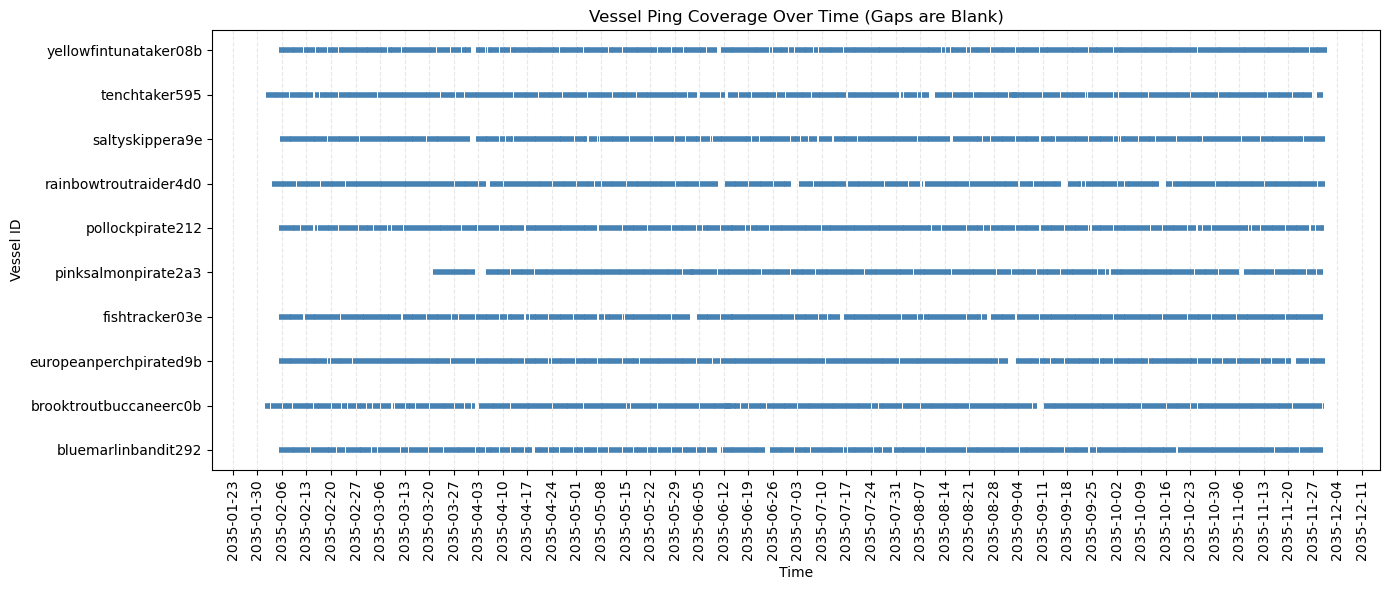

In [46]:
import matplotlib.dates as mdates

# Filter for top vessels with most gaps
top_gap_vessels = sorted_pings['target'].value_counts().head(10).index
timeline_data = sorted_pings[sorted_pings['target'].isin(top_gap_vessels)]

# Assign a y-position to each vessel
vessel_to_y = {vessel: i for i, vessel in enumerate(timeline_data['target'].unique())}

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

for _, row in timeline_data.iterrows():
    y = vessel_to_y[row['target']]
    ax.hlines(y, row['time'], row['end_time'], colors='steelblue', linewidth=4)

# Format y-axis with vessel IDs
ax.set_yticks(list(vessel_to_y.values()))
ax.set_yticklabels(list(vessel_to_y.keys()))
ax.set_ylabel('Vessel ID')

# Format x-axis as dates
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Vessel Ping Coverage Over Time (Gaps are Blank)')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.show()

Let's analyze the **harbor visits** of fishing vessels:

In [47]:
# Count number of visits per vessel
harbor_visit_counts = (
    harbor_reports_merged[harbor_reports_merged['vessel_type'].isin(['Entity.Vessel.FishingVessel'])]
    .groupby('source')
    .size()
    .sort_values(ascending=False)
    .reset_index()
)

print(harbor_visit_counts.to_string(index=True))

                            source   0
0                bluegillbandita5f  19
1           brooktroutbuccaneerc0b  18
2             whitefishwrangler7df  18
3              bluemarlinbandit292  16
4                perchplundererbc0  15
5                  musselmaster8d8  15
6          arcticgraylingangler094  15
7                  wavewranglerc2d  15
8                marinemarauder8c9  14
9                 herringhunter30b  14
10            yellowperchpiratec59  13
11                 perchpursuer982  13
12                        huron1b3  12
13             pinksalmonpirate2a3  12
14                   kingfisher87d  11
15                  flukefinder28d  11
16               mackerelmaster0a5  11
17                   codcatcher04c  11
18       tigermuskellungemaster012  11
19       chainpickerelplunderer039  11
20           rainbowtroutraider4d0  11
21                 saltyskippera9e  11
22                 zanderzealotb23  11
23                  turbottakerd86  11
24              catfishca

In [48]:
top_vessels_per_visits = harbor_visit_counts['source'].head(10).to_list()

# Filter only top vessels
top_vessel_visits = harbor_reports_merged[harbor_reports_merged['source'].isin(top_vessels_per_visits)].copy()

# Ensure date is datetime
top_vessel_visits['date'] = pd.to_datetime(top_vessel_visits['date'])

In [49]:
import itertools

# Create a full date range from earliest to latest date
all_dates = pd.date_range(top_vessel_visits['date'].min(), top_vessel_visits['date'].max(), freq='D')

# Create a base DataFrame with all vessel-date combinations
full_index = pd.DataFrame(list(itertools.product(top_vessels_per_visits, all_dates)), columns=['source', 'date'])

# Merge with real harbor visit data
harbor_merged = full_index.merge(
    top_vessel_visits[['source', 'date', 'target']], 
    on=['source', 'date'],
    how='left'
)

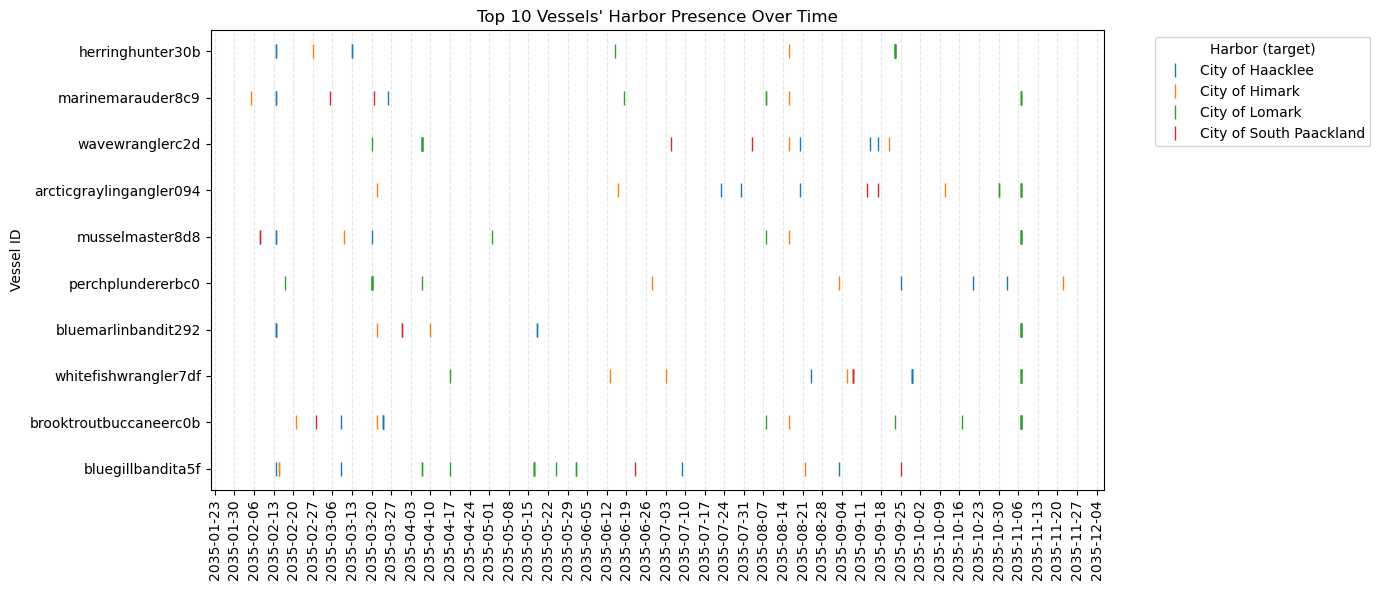

In [50]:
# Assign a numeric y-position to each vessel
vessel_to_y = {v: i for i, v in enumerate(top_vessels_per_visits)}
harbors = top_vessel_visits['target'].dropna().unique()
harbor_palette = dict(zip(harbors, sns.color_palette("tab10", len(harbors))))

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

for _, row in top_vessel_visits.iterrows():
    if pd.notna(row['target']):
        y = vessel_to_y[row['source']]
        ax.plot(row['date'], y, marker='|', color=harbor_palette[row['target']], markersize=10)

# Y-axis labels
ax.set_yticks(list(vessel_to_y.values()))
ax.set_yticklabels(list(vessel_to_y.keys()))
ax.set_ylabel("Vessel ID")

# X-axis formatting
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)

plt.title("Top 10 Vessels' Harbor Presence Over Time")
legend_handles = [
    plt.Line2D([0], [0], color=color, marker='|', linestyle='', markersize=10, label=harbor)
    for harbor, color in harbor_palette.items()
]
plt.legend(handles=legend_handles, title="Harbor (target)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.show()


# SouthSeafood Express Corp

In [51]:
# Filter nodes for SouthSeafood Express Corp
southseafood_vessels = node_data.query("company == 'SouthSeafood Express Corp'")

print("Vessels of SouthSeafood Express Corp:")
print(southseafood_vessels.to_string())

Vessels of SouthSeafood Express Corp:
                                           type name              Name Description Activities kind qty_tons date flag_country                    company tonnage length_overall style fish_species_present
snappersnatcher7be  Entity.Vessel.FishingVessel  NaN  Snapper Snatcher         NaN        NaN  NaN      NaN  NaN      Oceanus  SouthSeafood Express Corp     100             20   NaN                  NaN
roachrobberdb6      Entity.Vessel.FishingVessel  NaN      Roach Robber         NaN        NaN  NaN      NaN  NaN      Oceanus  SouthSeafood Express Corp   11700            130   NaN                  NaN


In [52]:
ranking_illegal_dwellers[ranking_illegal_dwellers['Vessel ID'].isin(southseafood_vessels.index)]

,Vessel ID,Total Dwell Time (hours)
79,snappersnatcher7be,235.258558


In [53]:
gap_df[gap_df['vessel_id'].isin(southseafood_vessels.index)]

,vessel_id,total_gap_hours
rank,,
173,roachrobberdb6,187.134413
175,snappersnatcher7be,119.910109


In [54]:
harbor_visit_counts[harbor_visit_counts['source'].isin(southseafood_vessels.index)]

,source,0
53,roachrobberdb6,9
158,snappersnatcher7be,6


## We can now try to spot suspicious behaviors

### 1. Was a vessel docked with no ping?

Sometimes, vessels may appear in **harbor reports** but are **missing transponder data** for the same time and location. Transponders are supposed to be always on — if a ship is docked but has no ping, it could mean the transponder was turned off intentionally (e.g., suspicious behavior).

### 2. Was a fish delivery preceded by a vessel visit?

If a harbor records a fish delivery, ideally a **vessel visit should have occurred just before**.

### 3. Transponder says vessel was far, but harbor report says it was docked

Sometimes, transponder data shows a vessel far away, while a harbor report claims it was present locally. It could indicate **spoofing** (fake transponder signal), identity fraud, or data tampering.

### Export Data for Use in Visual Analytics

In [55]:
# Save cleaned node and edge tables to CSV for external tools
# node_data.reset_index().rename(columns={'index': 'id'}).to_csv("graph_nodes.csv", index=False)
# edge_df.to_csv("graph_edges.csv", index=False)
# print("Data exported to CSV.")